In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import powerlaw, kstest
import numpy as np

In [2]:
# Step 1: Load and clean the data
def load_data(file_path):
    linkedin_data = pd.read_csv(file_path, skiprows=2, engine='python', 
                                names=["First Name", "Last Name", "URL", "Email Address", "Company", "Position", "Location"])
    return linkedin_data

In [3]:
# Step 2: Create the graph
def create_graph(data):
    G = nx.Graph()
    owner_node = "Owner"
    G.add_node(owner_node, role="Owner")

    for _, row in data.iterrows():
        connection_name = f"{row['First Name']} {row['Last Name']}"
        G.add_node(connection_name, company=row['Company'], position=row['Position'])
        G.add_edge(owner_node, connection_name)  # Connect owner to the connection

    return G

In [4]:
# Step 3: Add company-based edges
def add_company_edges(G, data):
    company_groups = data.groupby("Company")
    for company, group in company_groups:
        employees = group["First Name"] + " " + group["Last Name"]
        employee_list = employees.dropna().tolist()
        for i in range(len(employee_list)):
            for j in range(i + 1, len(employee_list)):
                G.add_edge(employee_list[i], employee_list[j], relationship="Colleagues")

In [5]:
# Step 4: Add location-based edges
def add_location_edges(G, data):
    location_groups = data.groupby("Location")
    for location, group in location_groups:
        people = group["First Name"] + " " + group["Last Name"]
        people_list = people.dropna().tolist()
        for i in range(len(people_list)):
            for j in range(i + 1, len(people_list)):
                G.add_edge(people_list[i], people_list[j], relationship="Same Location")


In [6]:
# Step 5: Analyze the graph
def analyze_graph(G):
    clustering_coefficient = nx.average_clustering(G)
    average_path_length = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
    return clustering_coefficient, average_path_length

In [7]:
# Step 6: Identify key influencers
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    centrality_df = pd.DataFrame({
        'Node': list(G.nodes),
        'Degree Centrality': degree_centrality.values(),
        'Betweenness Centrality': betweenness_centrality.values(),
        'Eigenvector Centrality': eigenvector_centrality.values()
    })

    top_influencers = centrality_df.sort_values(by='Degree Centrality', ascending=False).head(10)
    return top_influencers, degree_centrality

In [8]:
# Step 7: Visualize degree distribution
def plot_degree_distribution(G):
    degrees = [degree for _, degree in G.degree()]
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=range(1, max(degrees) + 2), align='left', edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Check for scale-free network
    plt.figure(figsize=(8, 6))
    plt.loglog(sorted(degrees, reverse=True), marker='o', linestyle='None')
    plt.title("Log-Log Plot of Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Fit power-law distribution
    degrees = np.array(degrees)
    alpha, loc, scale = powerlaw.fit(degrees)

    # Plot power-law fit
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=30, density=True, alpha=0.7, label='Degree Distribution')
    x = np.linspace(min(degrees), max(degrees), 100)
    plt.plot(x, powerlaw.pdf(x, alpha, loc, scale), 'r-', label=f'Power Law Fit (α={alpha:.2f})')
    plt.xlabel("Degree")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Degree Distribution and Power Law Fit")
    plt.show()

    # Perform Kolmogorov-Smirnov test
    D, p_value = kstest(degrees, 'powerlaw', args=(alpha, loc, scale))
    print(f"Kolmogorov-Smirnov Test: D = {D}, p-value = {p_value}")

In [9]:
# Step 8: Visualize the graph interactively
def visualize_graph_interactive(G, title="Graph Visualization"):
    pos = nx.spring_layout(G)

    # Extracting edge and node information for Plotly
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Assigning node colors based on community
    from networkx.algorithms.community import greedy_modularity_communities
    communities = list(greedy_modularity_communities(G))
    community_mapping = {node: i for i, community in enumerate(communities) for node in community}
    node_colors = [community_mapping[node] for node in G.nodes()]

    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node}<br>Degree: {G.degree[node]}<br>Community: {community_mapping[node]}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            color=node_colors,
            size=10,
            colorbar=dict(
                thickness=15,
                title='Community',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

    fig.show()

In [10]:
# Step 9: Explain metrics
def explain_metrics():
    explanations = {
        "Degree Centrality": "Indicates the number of direct connections a node has. Higher values suggest greater immediate influence.",
        "Betweenness Centrality": "Measures the extent to which a node lies on the shortest paths between other nodes. Higher values indicate a bridging role.",
        "Eigenvector Centrality": "Considers both the quantity and quality of connections. Nodes connected to influential nodes score higher.",
        "Average Path Length": "Indicates the average number of steps along the shortest paths for all pairs of nodes.",
        "Degree Distribution": "Describes how connections are distributed among nodes in the network. Scale-free networks typically exhibit a power-law degree distribution."
    }
    for metric, explanation in explanations.items():
        print(f"{metric}: {explanation}\n")

In [11]:
# Step 10: Main function to orchestrate the workflow
def main(file_path):
    data = load_data(file_path)
    G = create_graph(data)
    add_company_edges(G, data)
    add_location_edges(G, data)

    clustering_coefficient, average_path_length = analyze_graph(G)
    print(f"Clustering Coefficient: {clustering_coefficient}")
    if average_path_length is not None:
        print(f"Average Path Length: {average_path_length}")
    else:
        print("Graph is not connected; cannot compute average path length.")

    top_influencers, degree_centrality = compute_centrality_measures(G)
    print("Top Influencers:")
    print(top_influencers)

    explain_metrics()
    plot_degree_distribution(G)
    visualize_graph_interactive(G, title="Final Interactive Graph with Communities")

Clustering Coefficient: 0.6374254986316067
Average Path Length: 1.9835175409408528
Top Influencers:
                                Node  Degree Centrality  \
0                              Owner           1.000000   
128         Vitor Hugo Chaves Cambui           0.120493   
631         Filipe Wanderly da Silva           0.113852   
172          Murilo Gomes dos Santos           0.113852   
626                    Roberto Asano           0.113852   
627   Maria Luiza Brasil Fontes Leão           0.113852   
235                   Vinicius Silva           0.112903   
412                Patricia Carneiro           0.112903   
408                   Juliana Araújo           0.112903   
410  Jeniffer Damarys S. M. de Bedia           0.112903   

     Betweenness Centrality  Eigenvector Centrality  
0                  0.976407                0.100079  
128                0.001139                0.092489  
631                0.000204                0.092432  
172                0.000414       

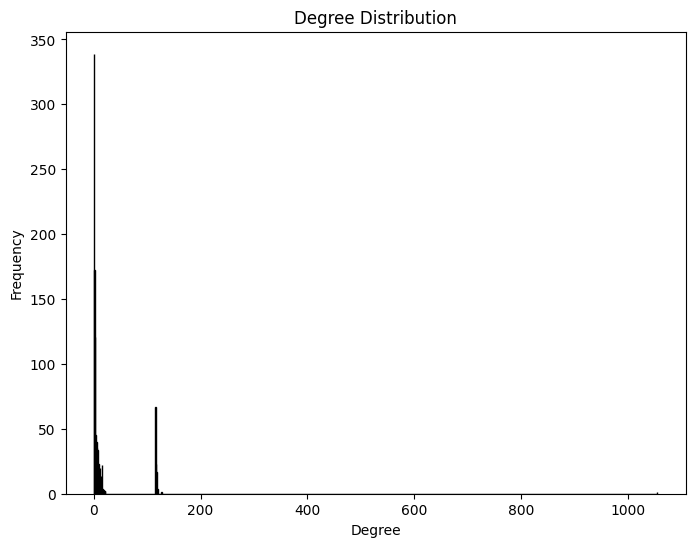

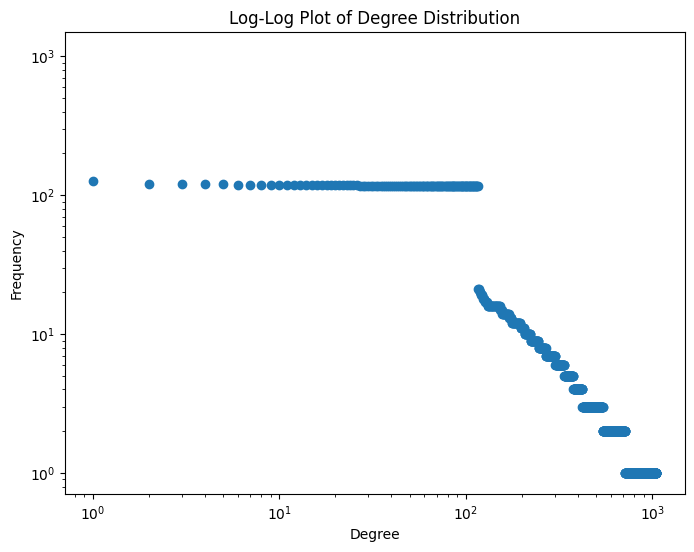

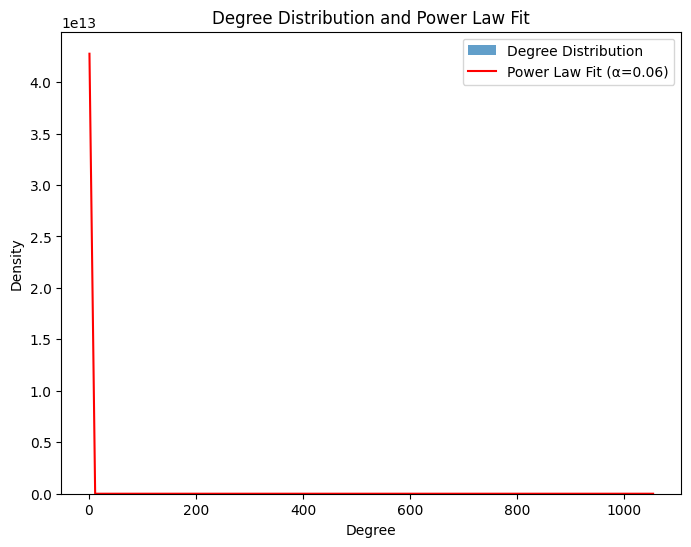

Kolmogorov-Smirnov Test: D = 0.3521260904906155, p-value = 1.7413807491971118e-117


In [12]:
main('..\small_world_linkedin\data\linkedin.csv')